In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Plotting adjustments
plt.rcParams["font.family"] = "Times New Roman"
sns.set_theme(style="whitegrid", font="Times New Roman", font_scale=0.8)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'figure.autolayout': True})

In [76]:
# Import excel files
classification = pd.read_excel('results.xlsx', sheet_name = 'Classification')
regression = pd.read_excel('results.xlsx', sheet_name = 'Regression')

In [77]:
# Group the data by summarisation method and task
grouped = classification.groupby(['Summarisation Method', 'Task', 'Model type'])

# Define a function to calculate the weighted average
weighted_avg = lambda x: np.average(x, weights=classification.loc[x.index, 'Support'])

# Initialize a new dataframe to store the results
classification_results = pd.DataFrame(columns=['Summarisation Method', 'Task', 'Macro F1-score', 'Micro F1-score', 'Weighted F1-score'])

# Calculate the macro, micro, and weighted averages for each group and store the results in the new dataframe
for name, group in grouped:
    precision = group['Precision']
    recall = group['Recall']
    F1 = group['F1-score']
    support = group['Support']
    
    # Calculate macro average
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    F1_macro = np.mean(F1)
    
    # Calculate micro average
    TP = sum(support * F1)
    FP = sum(support * (1 - precision))
    FN = sum(support * (1 - recall))
    precision_micro = TP / (TP + FP)
    recall_micro = TP / (TP + FN)
    F1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro)
    
    # Calculate weighted average
    precision_weighted = weighted_avg(precision)
    recall_weighted = weighted_avg(recall)
    F1_weighted = weighted_avg(F1)
    
    # Store the results in the new dataframe
    temp_df = pd.DataFrame({'Summarisation Method': name[0],
                            'Task': name[1],
                            'Model type': name[2],
                            'Macro F-1 score': F1_macro,
                            'Micro F-1 score': F1_micro,
                            'Weighted F-1 score': F1_weighted},
                            index=[0])
    classification_results = pd.concat([classification_results, temp_df], ignore_index=True)

# Sort alphabetically by model type and summarisation method and them task
classification_results.sort_values(by=['Model type', 'Summarisation Method', 'Task'], inplace=True)

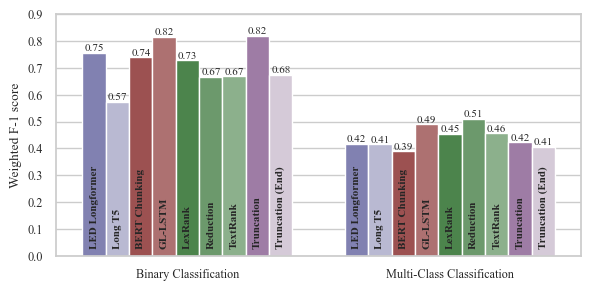

In [78]:
# Define the color palette for the plot
palette = {
    "Abstractive": sns.light_palette("navy", n_colors=5, reverse=True),
    "Extractive": sns.light_palette("darkred", n_colors=8, reverse=True),
    "Graph-based": sns.light_palette("darkgreen", n_colors=8, reverse=True),
    "No summarisation": sns.light_palette("#a275ac", n_colors=4, reverse=True),
}


# Create a custom color mapping for the Summarisation Methods
custom_mapping = {
    "LED Longformer": palette["Abstractive"][2],
    "Long T5": palette["Abstractive"][3],
    "BERT Chunking": palette["Extractive"][2],
    "GL-LSTM": palette["Extractive"][3],
    "LexRank": palette["Graph-based"][2],
    "Reduction": palette["Graph-based"][3],
    "TextRank": palette["Graph-based"][4],
    "Truncation": palette["No summarisation"][0],
    "Truncation (End)": palette["No summarisation"][2]
}

# Map the colors to the Summarisation Method
classification_results['Color'] = classification_results['Summarisation Method'].map(custom_mapping)

# Use seaborn to create the bar plot
fig = plt.figure(figsize=(6, 3))
ax = sns.barplot(x="Task", y="Weighted F-1 score", hue="Summarisation Method", data=classification_results, palette=classification_results['Color'][classification_results['Task'] == 'Binary Classification'])
ax.legend_.remove()
ax.set_xlabel(None)

# Add Summarisation methods and scores to the plot
for p, label, score in zip(ax.patches, classification_results['Summarisation Method'], classification_results['Weighted F-1 score']):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., 0.025),
                ha='center', va='bottom', rotation=90, weight = "bold", fontsize = 8,
                xytext=(0, 0), textcoords='offset points')
    ax.annotate('{:.2f}'.format(score), (p.get_x() + p.get_width() / 2., score),
                ha='center', va='bottom', rotation=0, fontsize = 8,
                xytext=(0, 00), textcoords='offset points')
    
# Adjust y limit
ax.set_ylim(0, 0.9)

fig.tight_layout()
fig.savefig('plots/classification_results.png', dpi=300, bbox_inches='tight')

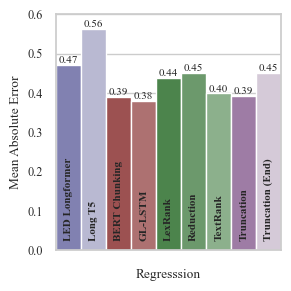

In [79]:
regression.sort_values(by=['Model type', 'Summarisation Method'], inplace=True)
regression['Color'] = regression['Summarisation Method'].map(custom_mapping)
regression['x_axis'] = np.arange(len(regression))


# Use seaborn to create the bar plot
fig = plt.figure(figsize=(3, 3))
ax = sns.barplot(x = 'x_axis', y="Mean Absolute Error", data=regression, palette=regression['Color'], width=1)
ax.set(xlabel="Regresssion", ylabel="Mean Absolute Error")
ax.set(xticklabels=[])

#Add Summarisation Method and MAE scores to the plot
for p, label, score in zip(ax.patches, regression['Summarisation Method'], regression['Mean Absolute Error']):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., 0.025),
                ha='center', va='bottom', rotation=90, weight = "bold", fontsize = 8,
                xytext=(0, 0), textcoords='offset points')
    ax.annotate('{:.2f}'.format(score), (p.get_x() + p.get_width() / 2., score),
                ha='center', va='bottom', rotation=0, fontsize = 8,
                xytext=(0, 0), textcoords='offset points')
    
# Adjust y limit
ax.set_ylim(0, 0.6)

fig.tight_layout()
fig.savefig('plots/regression_results.png', dpi=300, bbox_inches='tight')

In [80]:
binary_results = classification_results[classification_results['Task'] == "Binary Classification"][['Summarisation Method', 'Weighted F-1 score']]
binary_results.rename(columns={'Weighted F-1 score': 'Binary Classification'}, inplace=True)

multi_results = classification_results[classification_results['Task'] == "Multi-Class Classification"][['Summarisation Method', 'Weighted F-1 score']]
multi_results.rename(columns={'Weighted F-1 score': 'Multi-Class Classification'}, inplace=True)

reg_results = regression[['Summarisation Method', 'Mean Absolute Error']].rename(columns={'Mean Absolute Error': 'Regression'})

In [81]:
all_results = pd.merge(binary_results, multi_results, on='Summarisation Method')
all_results = pd.merge(all_results, reg_results, on='Summarisation Method')

In [82]:
# Drop the truncation method
all_results.drop(all_results[all_results['Summarisation Method'] == 'Truncation'].index, inplace=True)
all_results.drop(all_results[all_results['Summarisation Method'] == 'Truncation (End)'].index, inplace=True)
# Correlation between the three columns (excluding the ECHR Truncation method)
all_results[['Binary Classification', 'Multi-Class Classification', 'Regression']].corr()

,Binary Classification,Multi-Class Classification,Regression
Binary Classification,1.000000,0.150596,-0.743573
Multi-Class Classification,0.150596,1.000000,-0.256177
Regression,-0.743573,-0.256177,1.000000


In [83]:
train = pd.read_pickle('data/echr/non-anon_train.pkl')
test = pd.read_pickle('data/echr/non-anon_test.pkl')
valid = pd.read_pickle('data/echr/non-anon_valid.pkl')
df = pd.concat([train, test, valid])

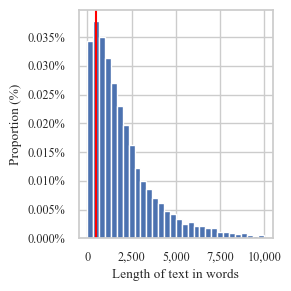

In [84]:
import matplotlib.ticker as tick # Plotting
fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(df['text'].str.split().apply(len), bins=30, range=(0,10_000), density=True)
plt.xlabel('Length of text in words')
plt.ylabel('Proportion (%)')
ax.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(tick.PercentFormatter(1.0, decimals=3))
ax.axvline(512, color='red', linestyle='-')
fig.savefig('plots/text_length_hist.png', dpi=300, bbox_inches='tight')